In [56]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops
from paretoviz.decorator import Arrow3D

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
# rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

<IPython.core.display.Javascript object>


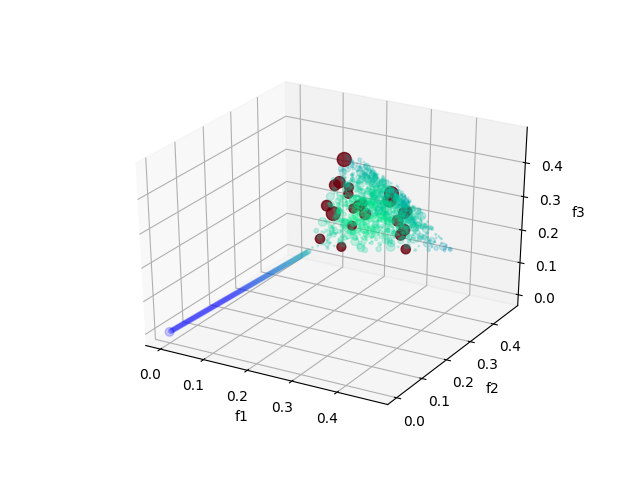

In [57]:
# use the original obj values for scatter plot.
rawpoints = fmt.load(rawfpath)
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()

In [58]:
# Compute PCA
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = len(rawpoints[0]))
pca.fit(np.array(rawpoints))
# pca_score = pca.explained_variance_ratio_

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


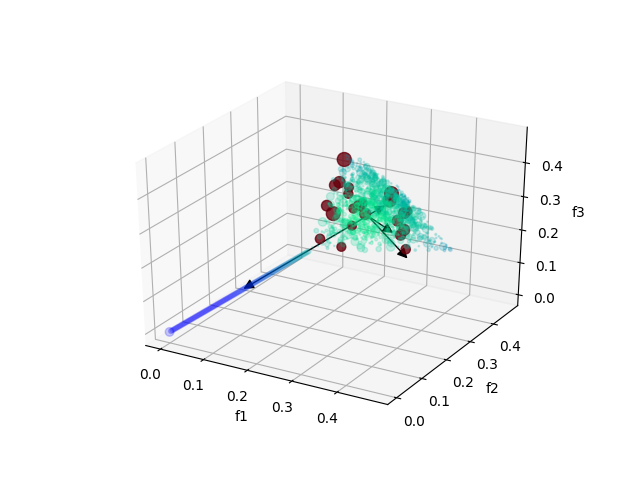

In [59]:
# Now do a scatter plot again with PCA directions
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    from_ = pca.mean_.tolist()
    to_ = (pca.mean_ + v).tolist()
    a = Arrow3D([from_[0], to_[0]], [from_[1], to_[1]], [from_[2], to_[2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = "black")
    ax.add_artist(a)

# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-pca.pdf")
plt.savefig(scatterfpath, transparent = False)
    
plt.show()

In [60]:
# Find the normal distances of all points from the first PC
import math

u = pca.components_[0].tolist()
m = pca.mean_.tolist()
pcldist = []
for p in rawpoints:
    x = [f - m[i] for i, f in enumerate(p)]
    x2 = math.fsum([v ** 2 for v in x])
    y = vops.dot(x, u)
    pcldist.append(math.sqrt(x2 - y * y))
print(pcldist[0:10])

[0.06963998104378476, 0.06827593675079074, 0.06691189663870292, 0.0655478609685315, 0.06418383002347894, 0.06281980411134029, 0.06145578356723578, 0.06009176875670804, 0.05872776007926616, 0.057363757972409016]


In [61]:
# Now peel according to the normal distance from the first PCA direction
m = len(points[0])
C = [[math.cos(t), math.sin(t)] for t in [2.0 * math.pi * (i/float(m)) for i in range(m)]]
b = vops.get_bound(points)
U = [[x / (b[1][i] - b[0][i]), y / (b[1][i] - b[0][i])] for i, [x, y] in enumerate(C)]

# Just map a single obj. vector to sc
def mapsc(f, inverted = True):
    p,q = 0.0, 0.0
    if inverted:
        f = [(1.0 - v) for v in f]
    p = math.fsum([f[i] * u[0] for i,u in enumerate(U)])
    q = math.fsum([f[i] * u[1] for i,u in enumerate(U)])
    return [p,q]
    
# Now recompute the palette coordinates w.r.t. to the distance
nlayers  = 4
idxs = sorted([i for i in range(0, len(pcldist))], key = lambda i: pcldist[i])
chunk = int(len(idxs) / nlayers) 

lidx = []
for l in range(nlayers):
    if l < nlayers - 1:
        lidx.extend([[i, l] for i in idxs[(l * chunk):(l * chunk) + chunk]])
    else:
        lidx.extend([[i, l] for i in idxs[(l * chunk):]])
lidx.sort()

palettefpath = os.path.join(".", prefix + "-norm-palette-invsc-pcldist.out")
fp = open(palettefpath, 'w')

for t in lidx:
    p, q = mapsc(points[t[0]])  
    fp.write("{0:.4f}\t{1:.4f}\t".format(p, q) + "{0:.4f}\n".format(t[1] * -1.0))

fp.close()
print("done.")

done.


<IPython.core.display.Javascript object>


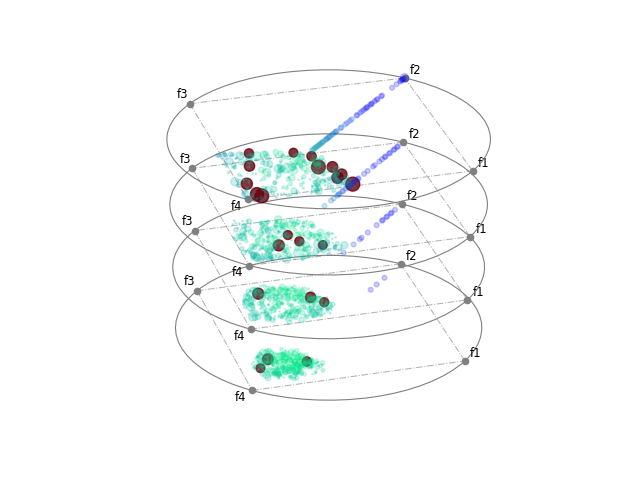

In [62]:
# Show the generic paletteviz
palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size, c = color, alpha = alpha, camera = dcor.cam_palette[prefix], \
            knee_idx = knee_idx, mode = "sc")
# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()

<IPython.core.display.Javascript object>


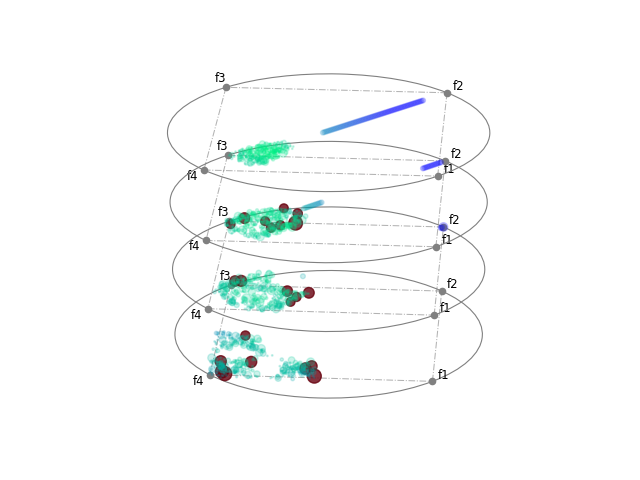

In [63]:
# Show the paletteviz constructed from the 1st PC distance
palette_coords = fmt.load(os.path.join(".", prefix + "-norm-palette-invsc-pcldist.out"))

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size, c = color, alpha = alpha, camera = dcor.cam_palette[prefix], \
            knee_idx = knee_idx, mode = "sc")
# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc-pcldist.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()

<IPython.core.display.Javascript object>


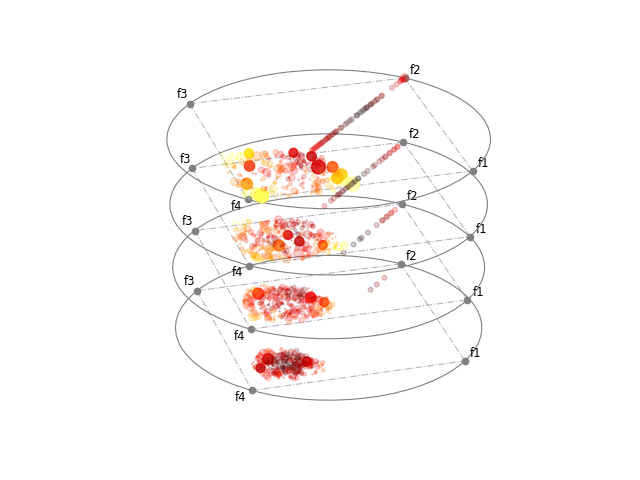

In [64]:
# Use the alpha-shape based layering but change the color w.r.t. pc distance
import matplotlib.cm as cm

# Discard the trade-off based coloring and use the coloring w.r.t. pc distance
[lb, ub] = vops.get_bound(pcldist)
npcldist = vops.normalize(pcldist, lb, ub)
color_pcl = [cm.hot(d) for d in npcldist]

palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size, c = color_pcl, alpha = alpha, camera = dcor.cam_palette[prefix], \
            knee_idx = knee_idx, mode = "sc")
# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-pclclr-invsc.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()

<IPython.core.display.Javascript object>


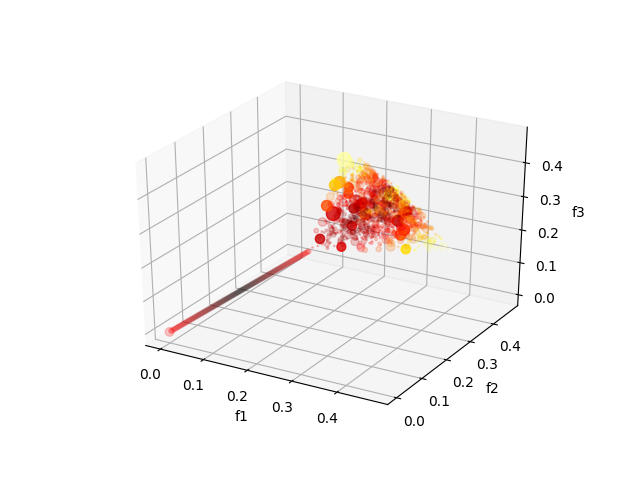

In [65]:
# do the scatter plot with color from 1st PC distance
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color_pcl, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-pclclr-scatter.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()